In [1]:
import os

from pydrake.common import temp_directory
from pydrake.geometry import StartMeshcat
from pydrake.systems.analysis import Simulator
from pydrake.visualization import ModelVisualizer
from pydrake.all import (
    Simulator,
    StartMeshcat,
)

from manipulation import FindResource, running_as_notebook
from manipulation.scenarios import AddMultibodyTriad
from manipulation import running_as_notebook
from manipulation.station import MakeHardwareStation, load_scenario

import os
import numpy as np
from pydrake.geometry import StartMeshcat
from pydrake.systems.analysis import Simulator

from manipulation import running_as_notebook
from manipulation.exercises.grader import Grader
from manipulation.exercises.robot.test_direct_joint_control import (
    TestDirectJointControl,
)
from manipulation.station import MakeHardwareStation, load_scenario

import numpy as np
from pydrake.all import (
    AbstractValue,
    ConstantVectorSource,
    DiagramBuilder,
    LeafSystem,
    PiecewisePose,
    RigidTransform,
    RotationMatrix,
    Simulator,
    StartMeshcat,
)

from manipulation import running_as_notebook
from manipulation.exercises.grader import Grader
from manipulation.exercises.pick.test_robot_painter import TestRobotPainter
from manipulation.meshcat_utils import AddMeshcatTriad
from manipulation.scenarios import AddIiwaDifferentialIK
from manipulation.station import MakeHardwareStation, load_scenario


from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    FindResourceOrThrow,
    Parser,
    RandomGenerator,
    SceneGraph,
    RigidTransform,
    Role,
    RollPitchYaw,
    Simulator,
    UniformlyRandomRotationMatrix,
    MakeRenderEngineVtk,
    RenderEngineVtkParams,
    RenderCameraCore,
    DepthRenderCamera,
    PointCloud,
    BaseField,
    Fields,
)

from pydrake.all import (
    AbstractValue, Adder, AddMultibodyPlantSceneGraph, BallRpyJoint, BaseField,
    Box, CameraInfo, ClippingRange,
    DepthImageToPointCloud, DepthRange, DepthRenderCamera, DiagramBuilder,
    FindResourceOrThrow,
    LeafSystem,
    MakeRenderEngineVtk, ModelInstanceIndex, Parser, RenderCameraCore,
    RenderEngineVtkParams, RgbdSensor, RigidTransform,
    RollPitchYaw, Role,
    ImageRgba8U, ImageDepth32F)

from manipulation.station import (
    AddPointClouds,
    MakeHardwareStation,
    load_scenario,
)

In [2]:
# Start the visualizer. The cell will output an HTTP link after the execution.
# Click the link and a MeshCat tab should appear in your browser.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [13]:
# Create a Drake temporary directory to store files.
# Note: this tutorial will create a temporary file (table_top.sdf)
# in the `/tmp/robotlocomotion_drake_xxxxxx` directory.
temp_dir = temp_directory()

# Create a table top SDFormat model.
table_top_sdf_file = os.path.join(temp_dir, "table_top.sdf")
table_top_sdf = """<?xml version="1.0"?>
<sdf version="1.7">

  <model name="table_top">
    <link name="table_top_link">
      <inertial>
        <mass>18.70</mass>
        <inertia>
          <ixx>0.79</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.53</iyy>
          <iyz>0</iyz>
          <izz>1.2</izz>
        </inertia>
      </inertial>
    <visual name="bottom">
        <pose>0.0 0.0 0.445 0 0 0</pose>
        <geometry>
          <box>
            <size>0.49 0.63 0.015</size>
          </box>
        </geometry>
        <material>
          <diffuse>0.9 0.9 0.9 1.0</diffuse>
        </material>
      </visual>
      <collision name="bottom">
        <pose>0.0 0.0 0.445 0 0 0</pose>
        <geometry>
          <box>
            <size>0.49 0.63 0.015</size>
          </box>
        </geometry>
        <drake:proximity_properties>
          <drake:compliant_hydroelastic/>
          <drake:hydroelastic_modulus>1.0e6</drake:hydroelastic_modulus>
        </drake:proximity_properties>
      </collision>
    </link>
    <frame name="table_top_center">
      <pose relative_to="table_top_link">0 0 0.47 0 0 0</pose>
    </frame>
  </model>
</sdf>

"""

with open(table_top_sdf_file, "w") as f:
    f.write(table_top_sdf)

In [14]:
cwd = os.getcwd()
your_model_filename = cwd+"/Board.sdf" # Write the absolute path to your file here

In [21]:
def convert_to_coords(pos):
    x = ord(pos[0]) - ord('a')
    y = int(pos[1])-1
    return "" + str(.6*.125*(y-3.5)) + ", "+ str(.6*.125*(x-3.5)+0.55) 

def get_coord_from_pos(pos):
    x = ord(pos[0]) - ord('a')
    y = int(pos[1])-1
    return [.6*.125*(y-3.5),.6*.125*(x-3.5)+0.55]

def get_starting_pose(pos):
    # They are flipped buy oh well
    x = ord(pos[0]) - ord('a')
    y = int(pos[1])-1
    return RigidTransform([.6*.125*(y-3.5), .6*.125*(x-3.5)+0.55, 0])

def add_piece(piece_id, name,  pos):
    return f"""
- add_model:
    name: {piece_id}
    file: file://{cwd}/{name}.sdf
    default_free_body_pose:
        {name}:
            translation: [{convert_to_coords(pos)}, .012]
            rotation: !Rpy {{ deg: [0, 0, 0] }}"""


In [30]:
scenario = None
def create_scene():
    global scenario
    scenario_data = f"""
directives:
- add_model:
    name: table_top
    file: file://{table_top_sdf_file}
- add_weld:
    parent: world
    child: table_top::table_top_center
"""
    scenario_data += """
    X_PC:
        translation: [0, 0.55, 0]
        rotation: !Rpy { deg: [0, 0, 0]}
"""
    if your_model_filename:
        scenario_data += f"""
- add_model:
    name: board
    file: file://{your_model_filename}
    default_free_body_pose:
        Board:
            translation: [0, 0.55, .01]
            rotation: !Rpy {{ deg: [90, 0, 0] }}    
"""
    scenario_data += add_piece('p1', 'BlackRook',  'b8')
    scenario_data += add_piece('p2', 'BlackBishop',  'c8')
    scenario_data += add_piece('p3', 'BlackRook',  'g8')
    scenario_data += add_piece('p4', 'BlackBishop',  'f8')
    scenario_data += add_piece('p5', 'BlackQueen',  'd8')
    scenario_data += add_piece('p6', 'BlackRook',  'a8')
    scenario_data += add_piece('p7', 'BlackRook',  'h8')
    scenario_data += add_piece('p8', 'BlackKing',  'e8') 
    scenario_data += add_piece('p9', 'WhiteRook',  'b1')
    scenario_data += add_piece('p10', 'WhiteBishop',  'c1')
    scenario_data += add_piece('p11', 'WhiteRook',  'g1')
    scenario_data += add_piece('p12', 'WhiteBishop',  'f1')
    scenario_data += add_piece('p13', 'WhiteQueen',  'd1')
    scenario_data += add_piece('p14', 'WhiteRook',  'a1')
    scenario_data += add_piece('p15', 'WhiteRook',  'h1')
    scenario_data += add_piece('p16', 'WhiteKing',  'e1')
    for i in range(8): 
       scenario_data += add_piece(f"p{17+i}", 'WhitePawn',  f"{chr(97+i)}2")
       scenario_data += add_piece(f"p{25+i}", 'BlackPawn',  f"{chr(97+i)}7")
    #scenario_data += add_piece('p1', 'WhitePawn',  'e2')
    
    scenario_data += """
- add_model:
    name: iiwa
    file: package://drake/manipulation/models/iiwa_description/sdf/iiwa14_no_collision.sdf
    default_joint_positions:
        iiwa_joint_1: [1.57]
        iiwa_joint_2: [0.1]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-1.2]
        iiwa_joint_5: [0]
        iiwa_joint_6: [ 1.6]
        iiwa_joint_7: [0]
- add_weld:
    parent: world
    child: iiwa::iiwa_link_0

- add_model:
    name: wsg
    file: package://manipulation/hydro/schunk_wsg_50_with_tip.sdf
- add_weld:
    parent: iiwa::iiwa_link_7
    child: wsg::body
    X_PC:
        translation: [0, 0, 0.09]
        rotation: !Rpy { deg: [90, 0, 90]}
- add_model:
    name: camera
    file: package://manipulation/camera_box.sdf
- add_weld:
    parent: wsg::body
    child: camera::base
    X_PC:
        translation: [0, 0.03, 0.04]
        # Point slightly down towards camera
        # RollPitchYaw(0, -0.2, 0.2) @ RollPitchYaw(-np.pi/2, 0, np.pi/2)
        rotation: !Rpy { deg: [-90, 0, 0] }
model_drivers:
    iiwa: !IiwaDriver
        hand_model_name: wsg
    wsg: !SchunkWsgDriver {}
cameras:
    main_camera:
        name: camera0
        depth: True
        X_PB:
            base_frame: camera::base
"""
    with open('board.yaml', 'w') as f:
        f.write(scenario_data)

    return scenario_data


#create_scene()

In [31]:
class PoseTrajectorySource(LeafSystem):
    def __init__(self, pose_trajectory):
        LeafSystem.__init__(self)
        self._pose_trajectory = pose_trajectory
        self.DeclareAbstractOutputPort(
            "pose", lambda: AbstractValue.Make(RigidTransform()), self.CalcPose
        )

    def CalcPose(self, context, output):
        output.set_value(self._pose_trajectory.GetPose(context.get_time()))
        

class RobotPlayer:

    def __init__(self, traj = None):
        builder = DiagramBuilder()
        #pass in which piece is moving and weld the others
        scenario_data = create_scene()
        scenario = load_scenario(data=scenario_data)
        self.station = builder.AddSystem(
            MakeHardwareStation(scenario, meshcat=meshcat)
        )
        self.plant = self.station.GetSubsystemByName("plant")
        # Remove joint limits from the wrist joint.
        self.plant.GetJointByName("iiwa_joint_7").set_position_limits(
            [-np.inf], [np.inf]
        )
        controller_plant = self.station.GetSubsystemByName(
            "iiwa.controller"
        ).get_multibody_plant_for_control()

        # optionally add trajectory source
        if traj is not None:
            traj_source = builder.AddSystem(PoseTrajectorySource(traj))
            self.controller = AddIiwaDifferentialIK(
                builder,
                controller_plant,
                frame=controller_plant.GetFrameByName("body"),
            )
            builder.Connect(
                traj_source.get_output_port(),
                self.controller.get_input_port(0),
            )
            builder.Connect(
                self.station.GetOutputPort("iiwa.state_estimated"),
                self.controller.GetInputPort("robot_state"),
            )

            builder.Connect(
                self.controller.get_output_port(),
                self.station.GetInputPort("iiwa.position"),
            )

        wsg_position = builder.AddSystem(ConstantVectorSource([0.1]))
        builder.Connect(
            wsg_position.get_output_port(),
            self.station.GetInputPort("wsg.position"),
        )

        self.diagram = builder.Build()
        self.gripper_frame = self.plant.GetFrameByName("body")
        self.world_frame = self.plant.world_frame()

        self.context = self.CreateDefaultContext()
        self.diagram.ForcedPublish(self.context)

    def visualize_frame(self, name, X_WF, length=0.15, radius=0.006):
        """
        visualize imaginary frame that are not attached to existing bodies

        Input:
            name: the name of the frame (str)
            X_WF: a RigidTransform to from frame F to world.

        Frames whose names already exist will be overwritten by the new frame
        """
        AddMeshcatTriad(
            meshcat, "painter/" + name, length=length, radius=radius, X_PT=X_WF
        )

    def CreateDefaultContext(self):
        context = self.diagram.CreateDefaultContext()
        plant_context = self.diagram.GetMutableSubsystemContext(
            self.plant, context
        )

        # provide initial states
        q0 = np.array(
            [
                1.57,
                0.4,
                0,
                -1.2,
                0,
                1.5,
                3.14,
            ]
        )
        # set the joint positions of the kuka arm
        iiwa = self.plant.GetModelInstanceByName("iiwa")
        self.plant.SetPositions(plant_context, iiwa, q0)
        self.plant.SetVelocities(plant_context, iiwa, np.zeros(7))
        wsg = self.plant.GetModelInstanceByName("wsg")
        self.plant.SetPositions(plant_context, wsg, [-0.05, 0.05])
        self.plant.SetVelocities(plant_context, wsg, [0, 0])

        return context

    def get_X_WG(self):
        plant_context = self.plant.GetMyMutableContextFromRoot(self.context)
        X_WG = self.plant.CalcRelativeTransform(
            plant_context, frame_A=self.world_frame, frame_B=self.gripper_frame
        )
        return X_WG

    def paint(self, sim_duration=20.0):
        simulator = Simulator(self.diagram, self.context)

        duration = sim_duration if running_as_notebook else 0.01
        simulator.AdvanceTo(duration)

        #check camera, make new trajectories
        #find next trajecotires
        #restart the robot 

In [32]:
painter = RobotPlayer()

X_WG = painter.get_X_WG()
print(X_WG)

coord = get_coord_from_pos('e2')
start = RigidTransform(
        RollPitchYaw(0,0,np.pi/2),
        [coord[0]+0.2, coord[1], 0.25]
)
mid = RigidTransform(
        RollPitchYaw(-np.pi/8,0,np.pi/2),
        [coord[0]+0.2, coord[1], 0.08]
)
final = RigidTransform(
        RollPitchYaw(-np.pi/8,0,np.pi/2),
        [coord[0]+0.08, coord[1], 0.08]
)

painter.visualize_frame("gripper_current", X_WG)
painter.visualize_frame("start", start)
painter.visualize_frame("middle", mid)
painter.visualize_frame("final", final)




ERROR: In vtkPNGReader.cxx, line 133
vtkPNGReader (0x55b52cbc68a0): Unknown file type! Not a PNG file!

ERROR: In vtkPNGReader.cxx, line 272
vtkPNGReader (0x55b52cbc68a0): Invalid file header: not a PNG file

ERROR: In vtkPNGReader.cxx, line 133
vtkPNGReader (0x55b52cbc68a0): Unknown file type! Not a PNG file!

ERROR: In vtkPNGReader.cxx, line 396
vtkPNGReader (0x55b52cbc68a0): Invalid file header: not a PNG file

ERROR: In vtkPNGReader.cxx, line 133
vtkPNGReader (0x55b5295b1610): Unknown file type! Not a PNG file!

ERROR: In vtkPNGReader.cxx, line 272
vtkPNGReader (0x55b5295b1610): Invalid file header: not a PNG file

ERROR: In vtkPNGReader.cxx, line 133
vtkPNGReader (0x55b5295b1610): Unknown file type! Not a PNG file!

ERROR: In vtkPNGReader.cxx, line 396
vtkPNGReader (0x55b5295b1610): Invalid file header: not a PNG file



RigidTransform(
  R=RotationMatrix([
    [0.9999996818349698, 3.311179214493656e-05, -0.0007970154127976675],
    [0.0007949493057301478, 0.041580649249386356, 0.9991348345761951],
    [6.622356329314716e-05, -0.9991351502732795, 0.04158060969768162],
  ]),
  p=[0.0004543007558398612, 0.5704952573763858, 0.5643136978639653],
)


==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html



In [37]:
total_time = 5
key_frame_poses = [X_WG, start, mid, final]
times = [0,1,2,5]
traj = PiecewisePose.MakeLinear(times, key_frame_poses)
print(traj)

In [43]:
painter = RobotPlayer(traj)
painter.paint(sim_duration=total_time)

ERROR: In vtkPNGReader.cxx, line 133
vtkPNGReader (0x55b532a143b0): Unknown file type! Not a PNG file!

ERROR: In vtkPNGReader.cxx, line 272
vtkPNGReader (0x55b532a143b0): Invalid file header: not a PNG file

ERROR: In vtkPNGReader.cxx, line 133
vtkPNGReader (0x55b532a143b0): Unknown file type! Not a PNG file!

ERROR: In vtkPNGReader.cxx, line 396
vtkPNGReader (0x55b532a143b0): Invalid file header: not a PNG file

ERROR: In vtkPNGReader.cxx, line 133
vtkPNGReader (0x55b53602ad80): Unknown file type! Not a PNG file!

ERROR: In vtkPNGReader.cxx, line 272
vtkPNGReader (0x55b53602ad80): Invalid file header: not a PNG file

ERROR: In vtkPNGReader.cxx, line 133
vtkPNGReader (0x55b53602ad80): Unknown file type! Not a PNG file!

ERROR: In vtkPNGReader.cxx, line 396
vtkPNGReader (0x55b53602ad80): Invalid file header: not a PNG file

==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due t

In [42]:
end_pose = painter.get_X_WG()
painter.visualize_frame("gripper_end", end_pose)

In [ ]:

"""
def buildAndRun(traj=None):
    global scenario
    builder = DiagramBuilder()
    hardware_station = create_scene()
    # plant, scene_graph = builder.AddMultibodyPlantSceneGraph(station.GetSubsystemByName("plant"), station.GetSubsystemByName("scene_graph"))
    station = builder.AddSystem(hardware_station)
    plant = station.GetSubsystemByName("plant")
    scene_graph = builder.AddSystem(SceneGraph())
    plant.GetJointByName("iiwa_joint_7").set_position_limits([-np.inf], [np.inf])

    # NOTE: This takes photos along the +z axis
    # IIRC +90 in the x axis to take photos away from gripper
    controller_plant = station.GetSubsystemByName(
        "iiwa.controller"
    ).get_multibody_plant_for_control()
    builder.ExportOutput(
        station.GetOutputPort("camera0.rgb_image"), "rgb_image"
    )
    builder.ExportOutput(
        station.GetOutputPort("camera0.depth_image"), "depth_image"
    )
    to_point_cloud = AddPointClouds(
        scenario=scenario, station=station, builder=builder, meshcat=meshcat
    )

    # Add a box for the camera in the environment.
    plant = station.GetSubsystemByName("plant")
    camera_instance = plant.GetModelInstanceByName("camera")
    scene_graph = station.GetSubsystemByName("scene_graph")
    AddMultibodyTriad(
        plant.GetFrameByName("base", camera_instance),
        scene_graph,
        length=0.1,
        radius=0.005,
    )

    # # Export the point cloud output.
    builder.ExportOutput(
        to_point_cloud["camera0"].point_cloud_output_port(), "point_cloud"
    )

    #here is where the controller is added 
    if traj is not None:
        traj_source = builder.AddSystem(PoseTrajectorySource(traj))
        controller = AddIiwaDifferentialIK(
            builder,
            controller_plant,
        )
        builder.Connect(
            traj_source.GetOutputPort("pose"),
            controller.get_input_port(0),
        )
        builder.Connect(
            station.GetOutputPort("iiwa.state_estimated"),
            controller.GetInputPort("robot_state"),
        )

        builder.Connect(
            controller.get_output_port(),
            station.GetInputPort("iiwa.position"),
        )

    wsg_position = builder.AddSystem(ConstantVectorSource([0]))
    builder.Connect(
        wsg_position.get_output_port(),
        station.GetInputPort("gripper.position"),
    )

    diagram = builder.Build()

    return diagram, plant, station"""

In [ ]:
# # TRAJ USED TO BE A traj = PiecewisePose.MakeLinear(times, key_frame_poses)
# # FIX THIS.
# import matplotlib.pyplot as plt
# start = RigidTransform(RollPitchYaw(0,0,0),[0,0,0])
# top = RigidTransform(RollPitchYaw(0,0,0),[0,0,0.1])
# num_key_frames = 1
# times = np.linspace(0, 20, num_key_frames + 1)
# key_frame_poses = [start, start]
# traj = PiecewisePose.MakeLinear(times, key_frame_poses)
# diagram, plant, station = buildAndRun(traj)

# simulator = Simulator(diagram)
# simulator.set_target_realtime_rate(1.0)

# duration = 20.0 if running_as_notebook else 0.01
# simulator.AdvanceTo(duration)


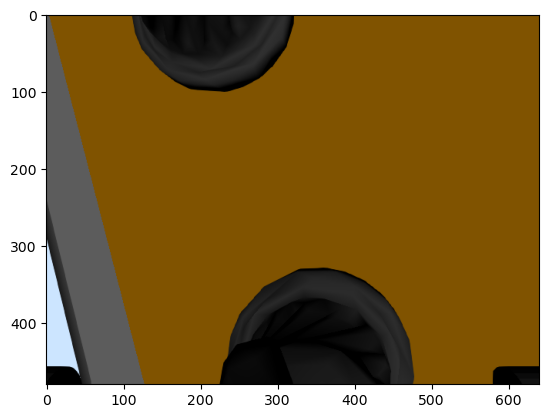

In [11]:
# station = diagram.GetSubsystemByName("station")
import matplotlib.pyplot as plt
img = diagram.GetOutputPort('rgb_image').Eval(context).data
# plt.plot(img)
plt.imshow(img)

In [35]:
img = diagram.GetOutputPort('point_cloud').Eval(context)


In [36]:
dir(img)

['C',
 'Crop',
 'D',
 'EstimateNormals',
 'FlipNormalsTowardPoint',
 'IsDefaultValue',
 'IsInvalidValue',
 'SetFields',
 'SetFrom',
 'T',
 'VoxelizedDownSample',
 '__class__',
 '__del__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_pybind11_del_orig',
 'fields',
 'has_normals',
 'has_rgbs',
 'has_xyzs',
 'kDefaultValue',
 'mutable_normal',
 'mutable_normals',
 'mutable_rgb',
 'mutable_rgbs',
 'mutable_xyz',
 'mutable_xyzs',
 'normal',
 'normals',
 'resize',
 'rgb',
 'rgbs',
 'size',
 'xyz',
 'xyzs']

## How will this notebook be Graded?

If you are enrolled in the class, this notebook will be graded using [Gradescope](www.gradescope.com). You should have gotten the enrollement code on our announcement in Piazza. 

This notebook only consists of written questions, so please submit all responses in your PDF submission to Gradescope. For this exercise, you should have completed the following subparts:
- Correct answers to part (a)
- Correct answers to part (b)
- A screenshot and description of your added object for part (c)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c8432d35-2370-4de9-924c-af3802cf315d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>